In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from scipy import stats
import numpy as np
import os
import warnings

DATA_FILE_NAME = '41467_2024_55320_MOESM6_ESM.csv'
NEEDED_SHAP_COLUMNS = [
    'MWCO-SHAP', 'CA-SHAP', 'Size-SHAP', 'logKow-SHAP',
    'Init_conc-SHAP', 'Pres-SHAP', 'IS-SHAP', 'charge_product-SHAP'
]

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [2]:
print("--- PART 1: DATA LOADING & DESCRIPTIVE STATS ---")

try:
    big_raw_data = pd.read_csv(DATA_FILE_NAME, low_memory=False)
except FileNotFoundError:
    raise FileNotFoundError(f"Error: The file '{DATA_FILE_NAME}' was not found.")

# Check columns
for col_name in NEEDED_SHAP_COLUMNS:
    if col_name not in big_raw_data.columns:
        raise ValueError(f"Missing SHAP column: {col_name}")

print("Data load successful. Focusing on SHAP columns.")
final_data_frame = big_raw_data[NEEDED_SHAP_COLUMNS].copy()

# Descriptive stats
stats_output = final_data_frame.agg(['mean', 'median', 'std']).T
print(stats_output)

--- PART 1: DATA LOADING & DESCRIPTIVE STATS ---
Data load successful. Focusing on SHAP columns.
                         mean    median       std
MWCO-SHAP           -0.048420 -0.506104  3.178252
CA-SHAP             -0.022994 -0.046922  0.933152
Size-SHAP           -0.063519  0.098079  1.291408
logKow-SHAP          0.094996  0.673828  2.227906
Init_conc-SHAP      -0.013979  0.363150  2.046136
Pres-SHAP           -0.108685 -0.063136  0.770157
IS-SHAP              0.121770  0.280487  1.034604
charge_product-SHAP  0.236854  1.359337  3.462738



--- PART 2: HISTOGRAMS ---


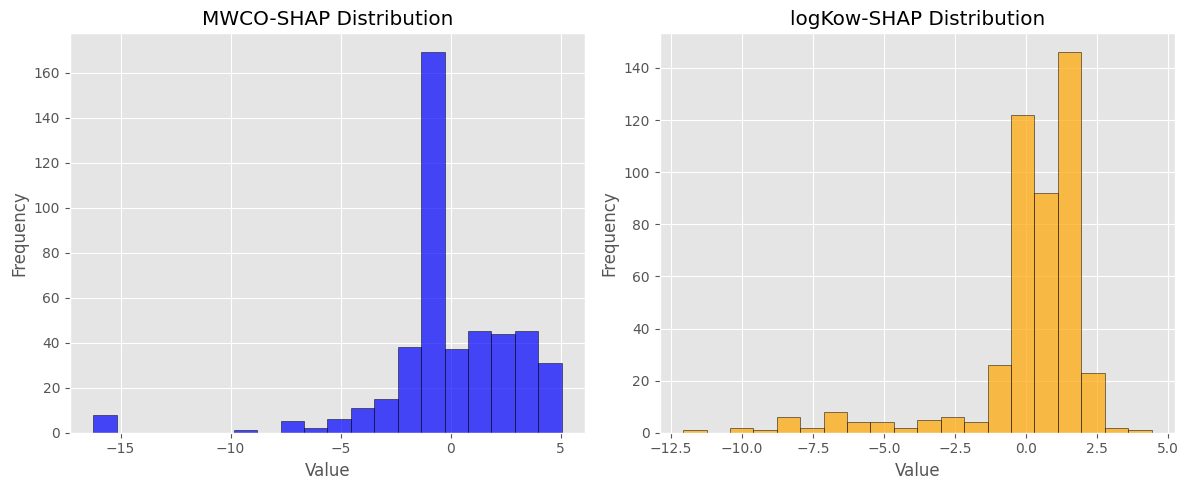

In [3]:
print("\n--- PART 2: HISTOGRAMS ---")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
final_data_frame['MWCO-SHAP'].hist(ax=axes[0], bins=20, edgecolor='black', color='blue', alpha=0.7)
axes[0].set_title('MWCO-SHAP Distribution')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')

final_data_frame['logKow-SHAP'].hist(ax=axes[1], bins=20, edgecolor='black', color='orange', alpha=0.7)
axes[1].set_title('logKow-SHAP Distribution')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('figure1_histograms.png')
plt.show()


In [4]:
print("\n--- PART 3: CORRELATION ANALYSIS ---")

target = 'charge_product-SHAP'
comparison_features = ['MWCO-SHAP', 'IS-SHAP', 'logKow-SHAP']
correlation_results = []

for feature in comparison_features:
    x = final_data_frame[feature].fillna(final_data_frame[feature].mean()).values
    y = final_data_frame[target].fillna(final_data_frame[target].mean()).values

    pearson_r, pearson_p = stats.pearsonr(x, y)
    spearman_r, spearman_p = stats.spearmanr(x, y)

    correlation_results.append({
        "Feature": feature,
        "Pearson_r": pearson_r,
        "Pearson_p": pearson_p,
        "Spearman_r": spearman_r,
        "Spearman_p": spearman_p
    })

corr_df = pd.DataFrame(correlation_results)
print(corr_df)
corr_df.to_csv("correlation_results.csv", index=False)


--- PART 3: CORRELATION ANALYSIS ---
       Feature  Pearson_r     Pearson_p  Spearman_r  Spearman_p
0    MWCO-SHAP   0.245657  1.044038e-07   -0.069623    0.137256
1      IS-SHAP   0.087854  6.057327e-02    0.122078    0.008992
2  logKow-SHAP   0.095418  4.146220e-02    0.028490    0.543515



--- PART 4: LINEAR REGRESSION SCATTER PLOTS ---


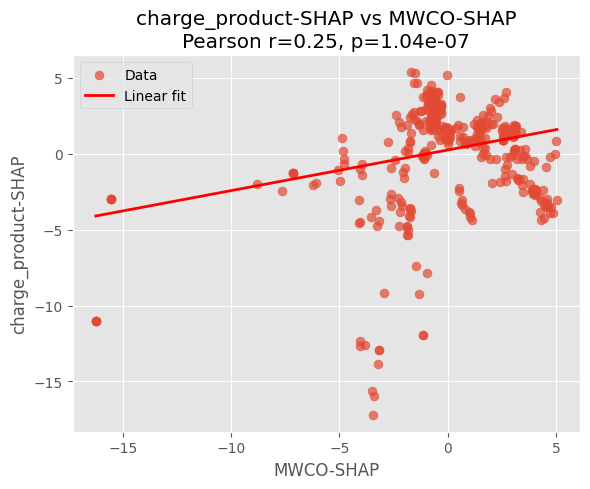

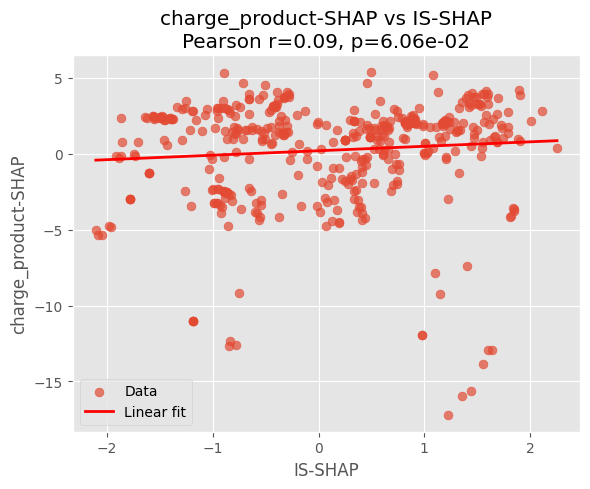

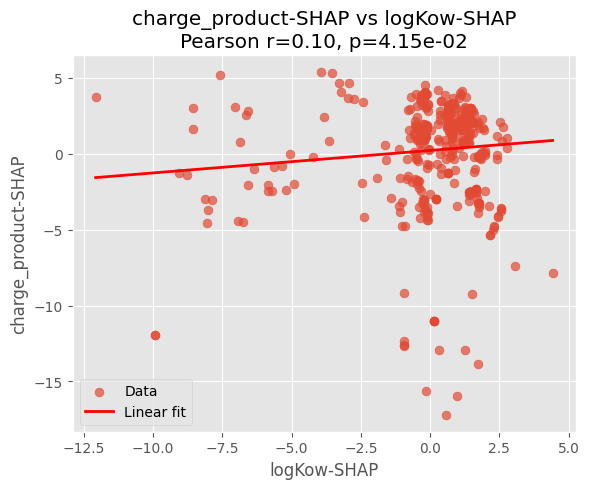

In [5]:
print("\n--- PART 4: LINEAR REGRESSION SCATTER PLOTS ---")

def scatter_with_reg(xcol, ycol, filename):
    X = final_data_frame[[xcol]].fillna(final_data_frame[xcol].mean()).values
    Y = final_data_frame[ycol].fillna(final_data_frame[ycol].mean()).values

    model = LinearRegression()
    model.fit(X, Y)

    x_line = np.linspace(X.min(), X.max(), 200).reshape(-1, 1)
    y_line = model.predict(x_line)

    plt.figure(figsize=(6, 5))
    plt.scatter(X, Y, s=40, alpha=0.7, label="Data")
    plt.plot(x_line, y_line, color="red", linewidth=2, label="Linear fit")

    pearson_r, pearson_p = stats.pearsonr(X.flatten(), Y)
    plt.title(f"{ycol} vs {xcol}\nPearson r={pearson_r:.2f}, p={pearson_p:.2e}")
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    plt.legend()
    plt.tight_layout()

    plt.savefig(filename, dpi=300)
    plt.show()   
    plt.close()

scatter_with_reg("MWCO-SHAP", target, "figure2_scatter_MWCO_vs_charge.png")
scatter_with_reg("IS-SHAP", target, "figure2_scatter_IS_vs_charge.png")
scatter_with_reg("logKow-SHAP", target, "figure2_scatter_logKow_vs_charge.png")


In [6]:
print("\n--- PART 5: PCA ---")

scaler_tool = StandardScaler()
normalized_data = scaler_tool.fit_transform(final_data_frame.fillna(final_data_frame.mean()))

pca_tool = PCA(n_components=len(final_data_frame.columns))
pca_scores_matrix = pca_tool.fit_transform(normalized_data)

variance_explained = pca_tool.explained_variance_ratio_
loading_weights = pd.DataFrame(pca_tool.components_.T,
                               columns=[f'PC{i}' for i in range(1, len(final_data_frame.columns)+1)],
                               index=final_data_frame.columns)

print("Variance explained by PC1:", variance_explained[0]*100, "%")
print("Variance explained by PC2:", variance_explained[1]*100, "%")


--- PART 5: PCA ---
Variance explained by PC1: 34.01276224061574 %
Variance explained by PC2: 16.689081669693493 %



--- PART 6: PCA LOADINGS PLOT ---


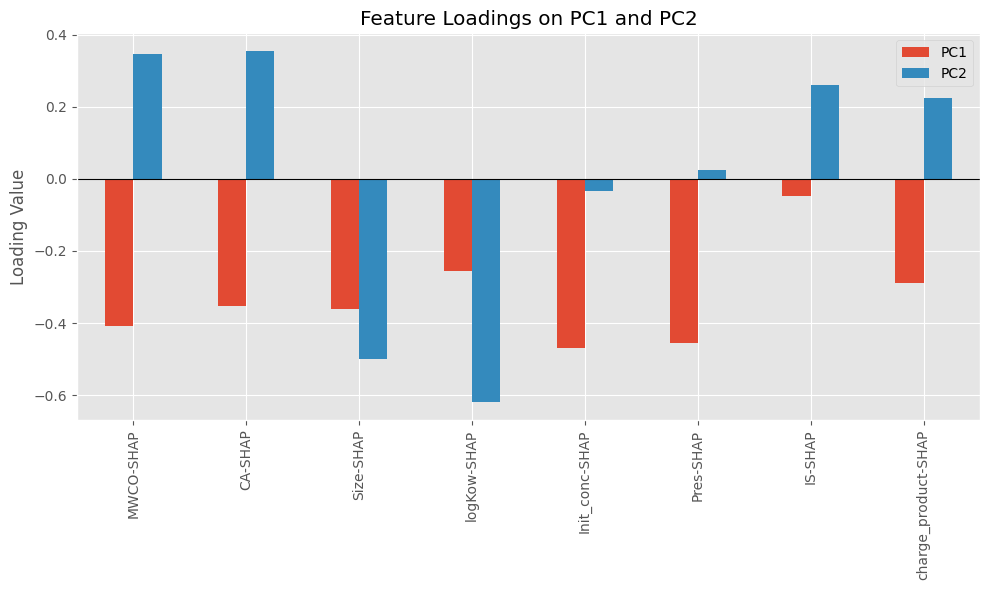

In [7]:
print("\n--- PART 6: PCA LOADINGS PLOT ---")

loading_weights[['PC1', 'PC2']].plot(kind='bar', figsize=(10, 6))
plt.title('Feature Loadings on PC1 and PC2')
plt.ylabel('Loading Value')
plt.axhline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.savefig('figure3_pca_loadings.png')
plt.show()



--- PART 7: PCA SCATTER PLOT ---


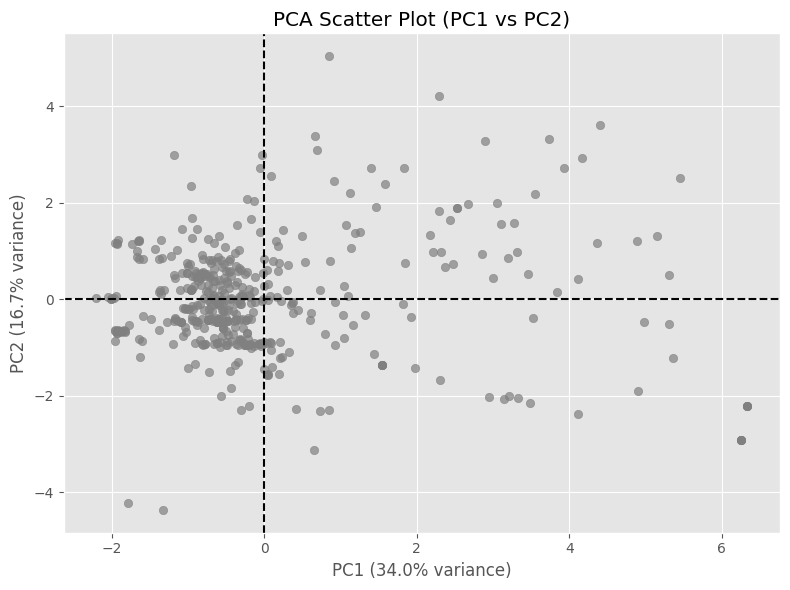

In [8]:
print("\n--- PART 7: PCA SCATTER PLOT ---")

scores_df = pd.DataFrame(pca_scores_matrix, columns=[f'PC{i}' for i in range(1, len(final_data_frame.columns)+1)])
plt.figure(figsize=(8, 6))
plt.scatter(scores_df['PC1'], scores_df['PC2'], alpha=0.7, color='gray')
plt.title('PCA Scatter Plot (PC1 vs PC2)')
plt.xlabel(f'PC1 ({variance_explained[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({variance_explained[1]*100:.1f}% variance)')
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')
plt.tight_layout()
plt.savefig('figure4_pca_scatter.png')
plt.show()


## 